In [1]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

In [2]:
df = pd.read_csv("GOOG (1).csv")

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,2.490664,2.591785,2.390042,2.499133,2.499133,897427216
1,2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488
2,2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939
3,2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159
4,2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512


In [4]:
df = df[["Date", "Close"]]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4698 entries, 0 to 4697
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    4698 non-null   object 
 1   Close   4698 non-null   float64
dtypes: float64(1), object(1)
memory usage: 73.5+ KB


In [6]:
df["Date"].min(), df["Date"].max()

('2004-08-19', '2023-04-18')

In [7]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], name='Close price'))
fig.update_layout(showlegend=True, title='Apple Inc. Stock Price 2004-2023')
fig.show()

In [8]:
train = df.loc[df['Date'] <= '2020-12-24']
test = df.loc[df['Date'] > '2020-12-24']
train.shape, test.shape

((4118, 2), (580, 2))

In [9]:
scaler = StandardScaler()
scaler = scaler.fit(np.array(train['Close']).reshape(-1,1))

train['Close'] = scaler.transform(np.array(train['Close']).reshape(-1,1))
test['Close'] = scaler.transform(np.array(test['Close']).reshape(-1,1))

<ipython-input-9-3e103d77f8ae>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-9-3e103d77f8ae>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



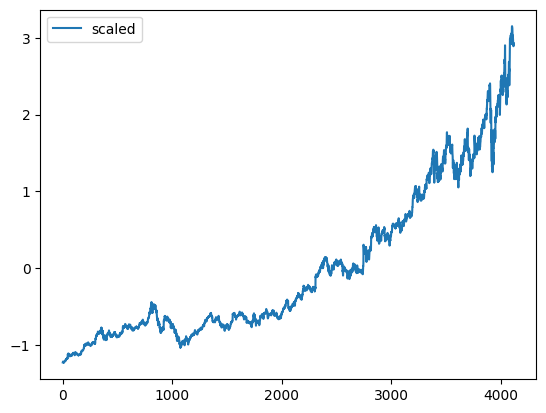

In [10]:
plt.plot(train['Close'], label = 'scaled')
plt.legend()
plt.show()

In [11]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    X_out, y_out = [], []
    for i in range(len(X)-time_steps):
        X_out.append(X.iloc[i:(i+time_steps)].values)
        y_out.append(y.iloc[i+time_steps])
    
    return np.array(X_out), np.array(y_out)

X_train, y_train = create_sequences(train[['Close']], train['Close'])
X_test, y_test = create_sequences(test[['Close']], test['Close'])
print("Training input shape: ", X_train.shape)
print("Testing input shape: ", X_test.shape)

Training input shape:  (4088, 30, 1)
Testing input shape:  (550, 30, 1)


In [13]:
np.random.seed(21)
tf.random.set_seed(21)

In [14]:
model = Sequential()
model.add(LSTM(128, activation = 'tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, activation = 'tanh', return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 30, 128)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed (TimeDistr  (None, 30, 1)            129       
 ibuted)                                                

In [15]:
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')],
                    shuffle=False)

Epoch 1/100
115/115 [==============================] - 12s 15ms/step - loss: 0.0526 - val_loss: 0.1147
Epoch 2/100
115/115 [==============================] - 1s 8ms/step - loss: 0.0210 - val_loss: 0.0909
Epoch 3/100
115/115 [==============================] - 1s 8ms/step - loss: 0.0126 - val_loss: 0.0649
Epoch 4/100
115/115 [==============================] - 1s 8ms/step - loss: 0.0127 - val_loss: 0.0538
Epoch 5/100
115/115 [==============================] - 1s 8ms/step - loss: 0.0148 - val_loss: 0.0629
Epoch 6/100
115/115 [==============================] - 1s 8ms/step - loss: 0.0125 - val_loss: 0.0502
Epoch 7/100
115/115 [==============================] - 1s 8ms/step - loss: 0.0096 - val_loss: 0.0520
Epoch 8/100
115/115 [==============================] - 1s 9ms/step - loss: 0.0122 - val_loss: 0.0515
Epoch 9/100
115/115 [==============================] - 1s 12ms/step - loss: 0.0103 - val_loss: 0.0693
Epoch 10/100
115/115 [==============================] - 1s 10ms/step - loss: 0.0096 - va

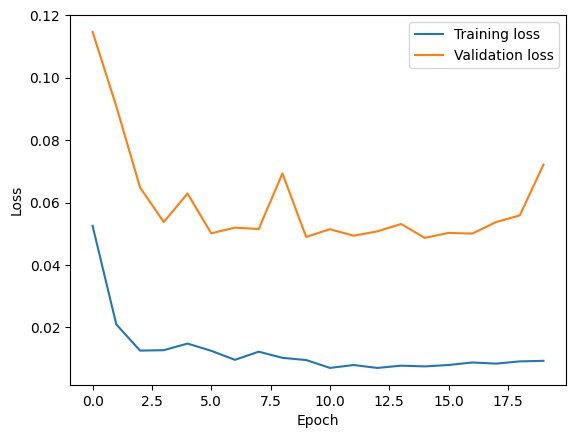

In [16]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

128/128 [==============================] - 2s 5ms/step
Reconstruction error threshold: 0.5572234220388699


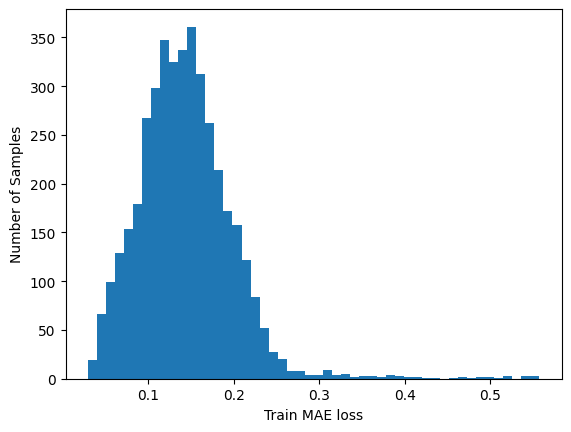

In [17]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

# Set reconstruction error threshold
threshold = np.max(train_mae_loss)

print('Reconstruction error threshold:',threshold)

18/18 [==============================] - 0s 4ms/step


Text(0, 0.5, 'Number of samples')

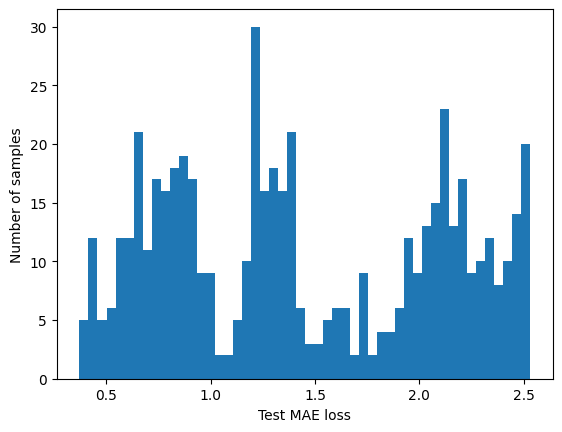

In [18]:
X_test_pred = model.predict(X_test, verbose=1)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

In [19]:
anomaly_df = pd.DataFrame(test[TIME_STEPS:])
anomaly_df['loss'] = test_mae_loss
anomaly_df['threshold'] = threshold
anomaly_df['anomaly'] = anomaly_df['loss'] > anomaly_df['threshold']

In [20]:
anomaly_df.head()


,Date,Close,loss,threshold,anomaly
4148,2021-02-10,3.806055,0.371511,0.557223,False
4149,2021-02-11,3.807311,0.394533,0.557223,False
4150,2021-02-12,3.827547,0.416520,0.557223,False
4151,2021-02-16,3.871345,0.444111,0.557223,False
4152,2021-02-17,3.887125,0.463349,0.557223,False


In [21]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [22]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]
anomalies.head()

,Date,Close,loss,threshold,anomaly
4156,2021-02-23,3.745689,0.587040,0.557223,True
4157,2021-02-24,3.805538,0.618225,0.557223,True
4158,2021-02-25,3.648445,0.639306,0.557223,True
4159,2021-02-26,3.661985,0.684974,0.557223,True
4160,2021-03-01,3.771909,0.718012,0.557223,True


In [23]:
anomalies.shape


(519, 5)

In [26]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df[['Date']], y=scaler.inverse_transform(anomaly_df[['Close']]), name='Close price'))
fig.add_trace(go.Scatter(x=anomalies[['Date']], y=scaler.inverse_transform(anomalies[['Close']]), mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()